Behavior of different numerical schemes for a moving shock wave.

We'll use a very busy road and a red light at x=4.  Cars will accumulate quickly in the front, where the max allowed density of cars will be between x=3 and x=4.  There is an incoming traffic of 50% the maximum allowed density ($\rho = 0.5 \rho_{max}$).

Mathematically it is $$\rho (x,0) = 0.5 \rho_{max}, 0 \leq x < 3$$
$$\rho (x,0) = \rho_{max}, 3 \leq x \leq 4$$

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
def rho_red_light(nx, rho_max, rho_in):
    """Computes 'red light' initial condition with shock
    
    Parameters
    ----------
    nx : int
        Number of grid points in x
    rho_max : float
        Maximum allowed car density
    rho_in : float
        Density of incoming cars
    
    Returns
    -------
    rho : array of floats
        Array with initial values of density
    """
    rho = rho_max*numpy.ones(nx)
    rho[:(nx-1)*3./4.] = rho_in
    return rho

In [3]:
#Basic initial condition parameters
#defining grid size, time steps, CFL condition, etc...
nx = 81
nt = 30
dx = 4.0/(nx-1)

rho_in = 5.
rho_max = 10.

u_max = 1.

x = numpy.linspace(0,4,nx)

rho = rho_red_light(nx, rho_max, rho_in)

/Users/Michael/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


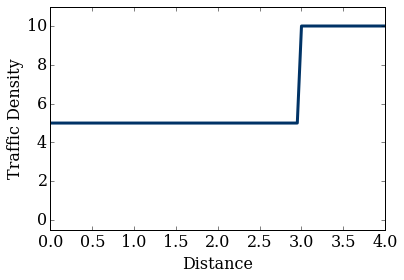

In [4]:
pyplot.plot(x, rho, color='#003366', ls='-', lw=3)
pyplot.ylabel('Traffic Density')
pyplot.xlabel('Distance')
pyplot.ylim(-0.5,11.);

**How will cars accumulate at the red light?**

The problem will be solved using three different numerical schemes and their performance will be looked at.

Lax-Friedrichs, Lax-Wendroff, and MacCormack

The wave speed $u_{wave}$ is -1 for $\rho = \rho _{max}$ and $\rho \leq \rho _{max} / 2$ which makes all velocities negative.  We should see a solution moving left, maintaining shock geometry. 

In [5]:
def computeF(u_max, rho_max, rho):
    """Computes flux F=V*rho
    
    Parameters
    ----------
    u_max : float
        Maximum allowed velocity
    rho : array of floats
        Array with density of cars at every point x
    rho_max : float
        Maximum allowed car density
        
    Returns
    -------
    F : array
        Array with flux at every point x
    """
    return u_max*rho*(1-rho/rho_max)

In [6]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

In [7]:
def animate(data):
    x = numpy.linspace(0,4,nx)
    y = data
    line.set_data(x,y)
    return line,

**Lax-Friedrichs scheme**
Conservation law for vehicle traffic gives the following for traffic density: $$\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0$$
F is traffic flux which in the linear traffic-speed model is given by: $$F = \rho u_{max} (1-\frac{\rho}{\rho _{max}})$$
In time, the natural choice for discretization is always a forward difference time because time invariably moves forward. $$\frac{\partial \rho}{\partial t} \approx \frac{1}{\Delta t} (\rho _i ^{n+1} - \rho _i ^n)$$
For space the simplest way to get second order accuray is to use central difference $$\frac{\partial F}{\partial x} \approx \frac{1}{2 \Delta x} (F_{i+1} - F_{i-1})$$
Combining these two for time and space discretization in the convection equation has catastrophic results.  The "forward-time, central scheme" (FTCS) is **unstable** (Definitely don't wanna try that)
The Lax-Friedrichs scheme (1954 by Lax) is a trick to stabilize the forward-time, central scheme.  The idea was to replace the solution value at $\rho _i ^n$ by the average of the values at the neighboring grid points.  This leads to: $$\frac{\rho _i ^{n+1} - \frac{1}{2} (\rho _{i+1} ^ n + \rho _{i-1} ^ n)}{\Delta t} = -\frac{F_{i+1} ^n - F_{i-1} ^n}{2 \Delta x}$$
This numerical discretization is **stable**. Unfortunately substituting $\rho _i ^n$ by the average of its neighbors introduces a first-order error.

To implement this sceheme in code, the value at the next step $\rho _i ^{n+1}$ needs to be isolated in order to write a time-step loop: $$\rho _i ^{n+1} = \frac{1}{2} (\rho _{i+1} ^n + \rho _{i-1} ^n) - \frac{\Delta t}{2 \Delta x} (F_{i+1} ^n - F_{i-1} ^2)$$

To display animations we're going to hold the results of each time-step in the variable rho which is a 2D array.  The resulting rho_n has nt rows and nx columns.

In [8]:
def laxfriedrichs(rho, nt, dt, dx, rho_max, u_max):
    """Computes the solution with Lax-Friedrichs scheme
    
    Parameters
    ----------
    rho : array of floats
        Density at current time-step
    nt : int
        Number of time steps
    dt : float
        Time-step size
    dx : float
        Mesh spacing
    rho_max : float
        Maximum allowed car density
    u_max : float
        Speed limit
    
    Returns
    -------
    rho_n : array of floats
        Density after nt time steps at every point x
    """
    
    # Initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))
    #Copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()
    
    """
    Now, for each timestep, we're going to calculate rho^n+1,
    then set the value of rho equal to rho^n+1 so we can calculate
    the next iteration.  For every timestep, the entire vector
    rho^n is saved in a single row of our results array rho_n.
    """
    for t in range(1,nt):
        F = computeF(u_max, rho_max, rho)
        rho_n[t,1:-1] = .5*(rho[2:]+rho[:-2]) - dt/(2*dx)*(F[2:]-F[:-2])
        rho_n[t,0] = rho[0] #boundary contion at x=0
        rho_n[t,-1] = rho[-1] #boundary condition at x=4
        rho = rho_n[t].copy()
        
    return rho_n

In [9]:
#Trying Lax-Friedrichs with CFL = 1
sigma = 1.0
dt = sigma*dx/u_max

rho = rho_red_light(nx, rho_max, rho_in) #make sure that u is set to our expected initial conditions
rho_n = laxfriedrichs(rho, nt, dt, dx, rho_max, u_max)

/Users/Michael/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [10]:
rho_n.shape
#should be nt(30) by nx(81)

(30, 81)


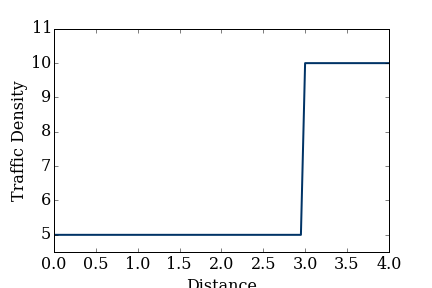
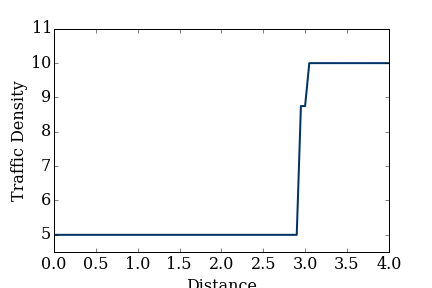
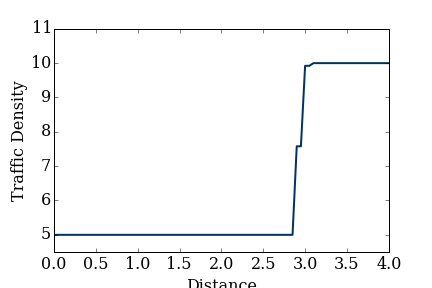
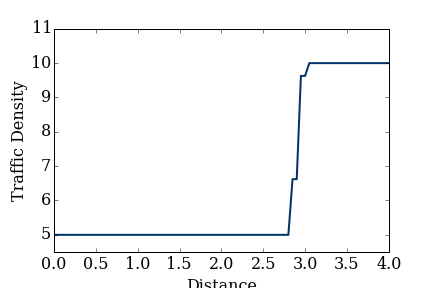
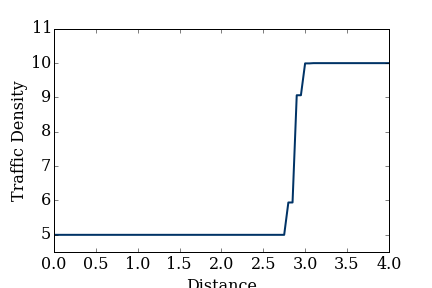
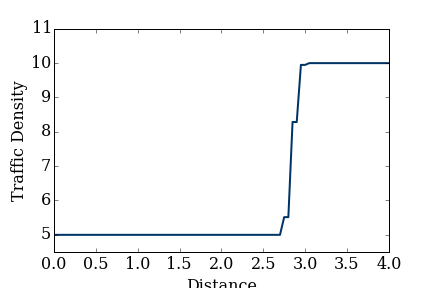
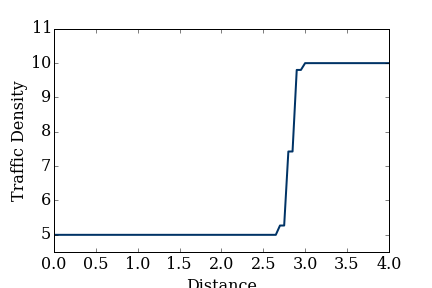
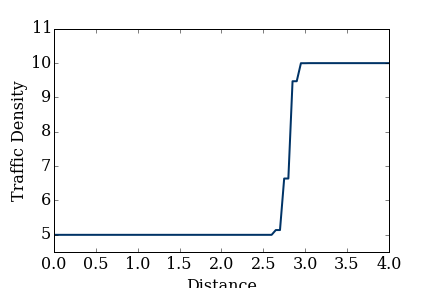
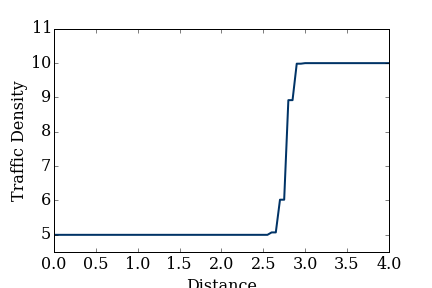
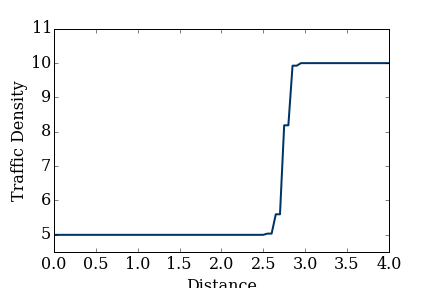
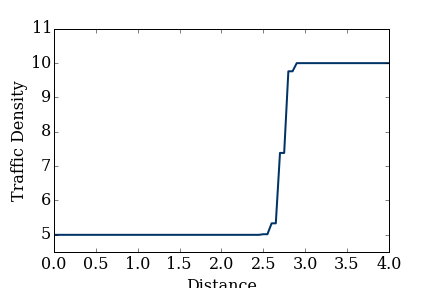
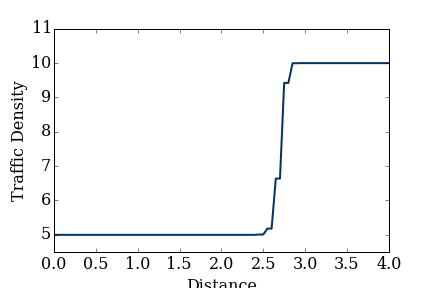
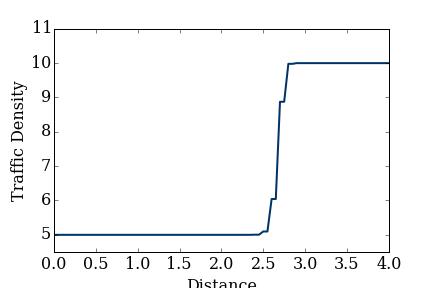
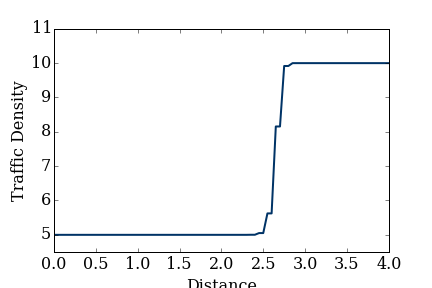
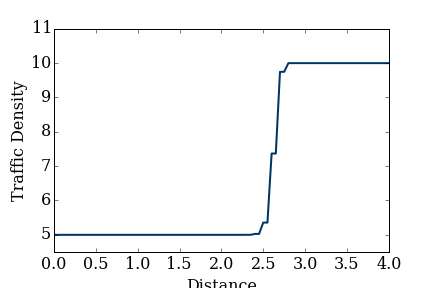
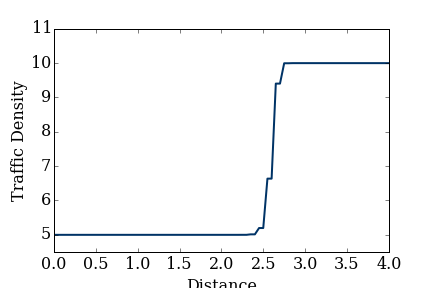
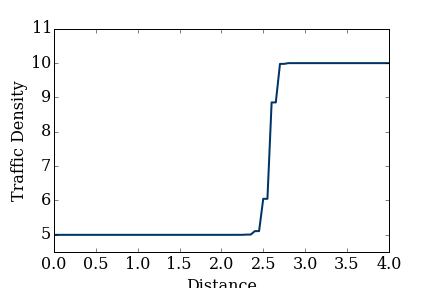
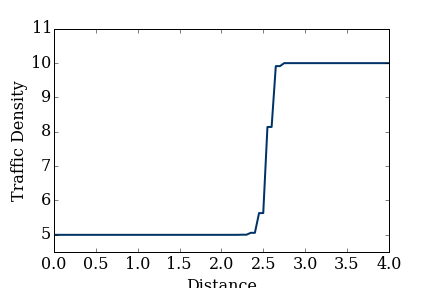
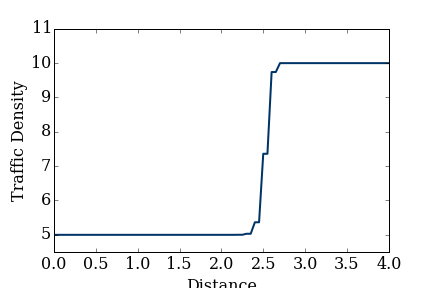
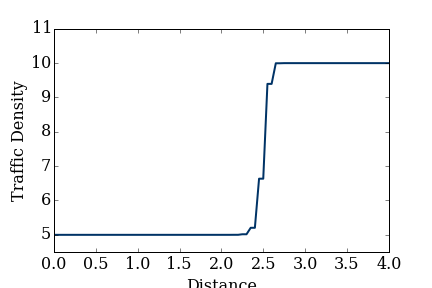
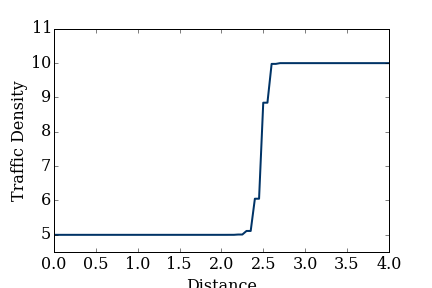
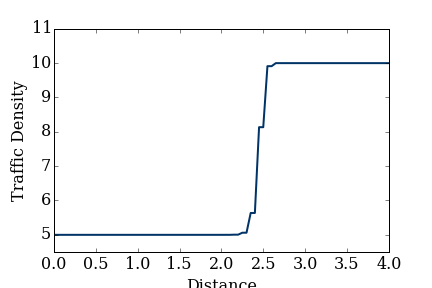
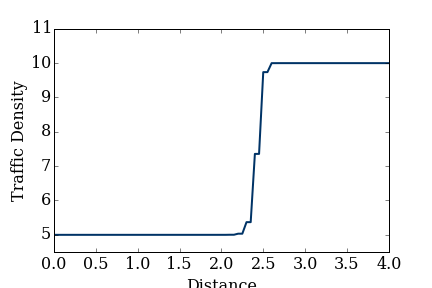
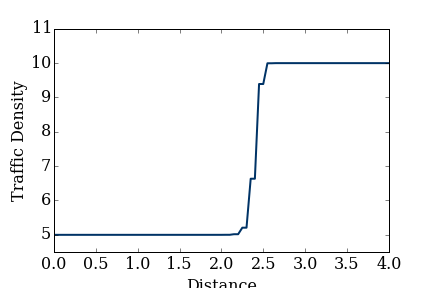
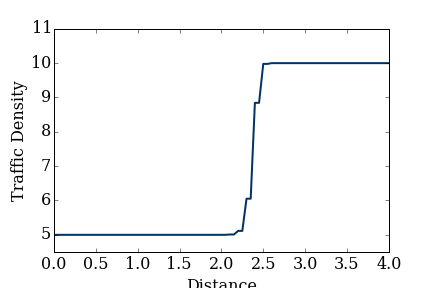
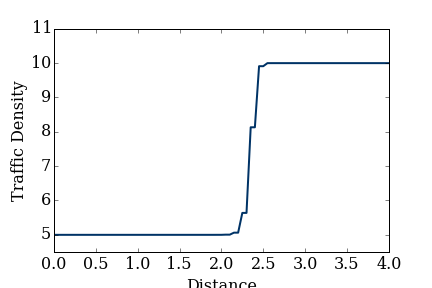
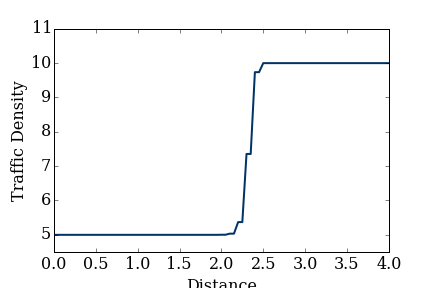
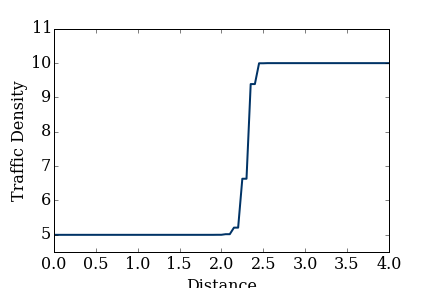
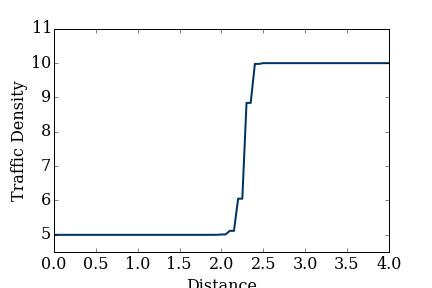
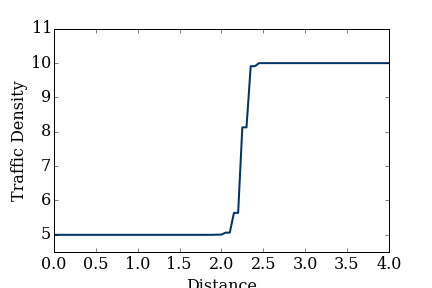

In [11]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4), ylim=(4.5,11), xlabel=('Distance'), ylabel=('Traffic Density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

In [12]:
#Lax-Friedrichs with CFL = .5
sigma = 0.5
dt = sigma*dx/u_max

rho = rho_red_light(nx, rho_max, rho_in) #make sure that u is set to our expected initial conditions
rho_n = laxfriedrichs(rho, nt, dt, dx, rho_max, u_max)

/Users/Michael/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
